In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
path = "/content/drive/My Drive/M2/DeepLearning"

import sys
sys.path.append(path)

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [2]:
from tensorflow import keras

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
print(train_images.shape)
print(test_images.shape)


import mnist_reader
X_train, y_train = mnist_reader.load_mnist(path+'/Datasets', kind='train')
X_test, y_test = mnist_reader.load_mnist(path+'/Datasets', kind='t10k')
print(X_train.shape)
print(X_test.shape)

X_train, X_test, train_images, test_images = X_train / 255.0, X_test / 255.0, train_images / 255.0, test_images / 255.0
#X_train, X_test, train_images, test_images = X_train / 127.5 - 1, X_test / 127.5 - 1, train_images / 127.5 - 1, test_images / 127.5 - 1

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 784)
(10000, 784)


### **1. Deep Autoencoder**

In [0]:
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score



#################################################
# Hyper-parameters
#################################################
epoch = 200
batch_size = 256

encoding_dim = 7*7
hidden_dim = 512

activation='elu'
optimizer='adam'
loss='mean_squared_error'
loss='binary_crossentropy'
#################################################

out_activation = 'sigmoid' if loss=='binary_crossentropy' else 'linear'
if activation=='leaky_relu':
  activation=None

#################################################
# Auto-encoder
#################################################
input_img = Input(shape=(784,))


####### Encoder #######
#   Layer
encoded = Dense(hidden_dim, activation=activation)(input_img)
if activation is None: encoded = layers.LeakyReLU()(encoded)

#   Layer
encoded = Dense(hidden_dim//4, activation=activation)(encoded)
if activation is None: encoded = layers.LeakyReLU()(encoded)

#   Layer
encoded = Dense(encoding_dim, activation=out_activation)(encoded)


####### Decoder #######
#   Layer
decoded = Dense(hidden_dim//4, activation=activation)(encoded)
if activation is None: decoded = layers.LeakyReLU()(decoded)

#   Layer
decoded = Dense(hidden_dim, activation=activation)(decoded)
if activation is None: decoded = layers.LeakyReLU()(decoded)

#   Layer
decoded = Dense(784, activation=out_activation)(decoded)


####### Make model #######
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer, loss=loss)

autoencoder.summary()


####### Train #######
autoencoder.fit(X_train, X_train,
                epochs=epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, X_test))


####### Encode images #######
encoder = Model(input_img, encoded)
encoded_images = encoder.predict(X_train)
#################################################



#################################################
# KMeans
#################################################
print("run KMeans")
kmeans = KMeans(n_clusters=10, n_init=20)
kmeans.fit(encoded_images)

print(nmi(kmeans.labels_, y_train))
print(ari(kmeans.labels_, y_train))
#################################################

### **2. Deep Convolutional Autoencoder**

In [0]:
from tensorflow import keras
from tensorflow.keras import Input, layers, models
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from math import sqrt

nmi = normalized_mutual_info_score
ari = adjusted_rand_score



#################################################
# Hyper-parameters
#################################################
epoch = 100
batch_size = 256

encoding_dim = 7*7

#activation='elu'
activation='leaky_relu'
optimizer='adam'
#loss='mean_squared_error'
loss='binary_crossentropy'
#################################################

encoding_size = int(sqrt(encoding_dim))
out_activation = 'sigmoid' if loss=='binary_crossentropy' else 'linear'
if activation=='leaky_relu':
  activation=None

def make_conv_autoencoder_model():
  #################################################
  # Convolutional Auto-encoder
  #################################################
  input_img = Input((28, 28, 1))


  ####### Encoder #######
  #   Layer
  encoded = layers.Conv2D(32, (3, 3), activation=activation)(input_img)
  if activation is None: encoded = layers.LeakyReLU()(encoded)
  encoded = layers.MaxPooling2D((2, 2))(encoded)

  #   Layer
  encoded = layers.Conv2D(64, (3, 3), activation=activation)(encoded)
  if activation is None: encoded = layers.LeakyReLU()(encoded)
  encoded = layers.MaxPooling2D((2, 2))(encoded)

  #   Layer
  encoded = layers.Conv2D(64, (3, 3), activation=activation)(encoded)
  if activation is None: encoded = layers.LeakyReLU()(encoded)

  #   Layer
  encoded = layers.Flatten()(encoded)
  encoded = layers.Dense(encoding_dim, activation=out_activation)(encoded)


  ####### Decoder #######
  decoded = layers.Reshape((encoding_size,encoding_size,1))(encoded)
  #   Layer
  decoded = layers.Conv2DTranspose(64,(3, 3), strides=2, activation=activation, padding='same')(decoded)
  decoded = layers.BatchNormalization()(decoded)
  if activation is None: decoded = layers.LeakyReLU()(decoded)

  #   Layer
  decoded = layers.Conv2DTranspose(64,(3, 3), strides=2, activation=activation, padding='same')(decoded)
  decoded = layers.BatchNormalization()(decoded)
  if activation is None: decoded = layers.LeakyReLU()(decoded)

  #   Layer
  decoded = layers.Conv2DTranspose(32,(3, 3), activation=activation, padding='same')(decoded)
  decoded = layers.BatchNormalization()(decoded)
  if activation is None: decoded = layers.LeakyReLU()(decoded)

  #   Layer
  decoded = layers.Conv2D(1, (3, 3), activation=out_activation, padding='same')(decoded)


  ####### Make model #######
  autoencoder = models.Model(input_img, decoded)

  return autoencoder, encoded, decoded

In [0]:
autoencoder, encoded, decoded = make_conv_autoencoder_model()
autoencoder.compile(optimizer=optimizer, loss=loss)

autoencoder.summary()

####### Train #######
autoencoder.fit(train_images, train_images,
                epochs=epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(test_images, test_images))


####### Encode images #######
encoder = Model(input_img, encoded)
encoded_images = encoder.predict(train_images)
print(encoded_images.shape)
#################################################



#################################################
# KMeans
#################################################
print("run KMeans")
kmeans = KMeans(n_clusters=10, n_init=20)
kmeans.fit(encoded_images)

print(nmi(kmeans.labels_, train_labels))
print(ari(kmeans.labels_, train_labels))
#################################################

### **3. Deep Convolutional Adversarial Autoencoder**

In [22]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers, models, Input
import numpy as np
from statistics import mean

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)



#################################################
# Hyper-parameters
#################################################
batch_size = 256

epoch = 100
noise_dim = 100

n_filter = 128
#################################################



def make_optimizer():
  return tf.keras.optimizers.Adam(1e-4)  
  return tf.keras.optimizers.Adam()

#################################################
# Generator
#################################################
def make_generator_model():
    input_img = Input((100, ))
    layer = layers.Dense(7*7*n_filter, use_bias=False)(input_img)
    layer = layers.BatchNormalization()(layer)
    layer = layers.LeakyReLU()(layer)

    layer = layers.Reshape((7, 7, n_filter))(layer)
    #assert model.output_shape == (None, 7, 7, n_filter) # Note: None is the batch size

    layer = layers.Conv2DTranspose(n_filter//2, (5, 5), strides=(1, 1), padding='same', use_bias=False)(layer)
    #assert model.output_shape == (None, 7, 7, n_filter//2)(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.LeakyReLU()(layer)

    layer = layers.Conv2DTranspose(n_filter//4, (5, 5), strides=(2, 2), padding='same', use_bias=False)(layer)
    #assert model.output_shape == (None, 14, 14, n_filter//4)(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.LeakyReLU()(layer)

    layer = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid')(layer)
    #assert model.output_shape == (None, 28, 28, 1)

    model = models.Model(input_img, layer)

    return model

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def make_generator_optimizer():
    return make_optimizer()  
    return tf.keras.optimizers.Adam(1e-4)  
#################################################


def make_autoencoder_optimizer():
  return make_optimizer()  
  return tf.keras.optimizers.Adam(1e-4) 

def autoencoder_loss(real_output):
  return cross_entropy(tf.ones_like(real_output), real_output)

#################################################
# Discriminator
#################################################
def make_disc(input_img):
    layer = layers.Conv2D(n_filter//4, (5, 5), strides=(2, 2), padding='same',)(input_img)
    layer = layers.LeakyReLU()(layer)
    #layer = layers.Dropout(0.3)(layer)

    layer = layers.Conv2D(n_filter//2, (5, 5), strides=(2, 2), padding='same')(layer)
    layer = layers.LeakyReLU()(layer)
    #layer = layers.Dropout(0.3)(layer)

    layer = layers.Flatten()(layer)
    layer = layers.Dense(1)(layer)

    model = models.Model(input_img, layer)

    return model

def make_discriminator_model():
    input_img = Input((28, 28, 1))
    return make_disc(input_img)

def make_discriminator_optimizer():
    return make_optimizer()  
    return tf.keras.optimizers.Adam(1e-4) 

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
#################################################   

def make_gan(generator, discriminator):
	model = models.Sequential()
	
	model.add(generator)
	model.add(discriminator)
	
	opt = make_discriminator_optimizer()
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

def make_aae(autoencoder, discriminator):
	model = models.Sequential()
	
	model.add(autoencoder)
	model.add(discriminator)
	
	opt = make_optimizer()
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model  
#################################################   


num_examples_to_generate=16
def generate_and_save_images(model, epoch, test_input=tf.random.normal([num_examples_to_generate, noise_dim]), norm=0):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255.0, cmap='gray')
      #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

def generate_images(batch_size, noise_dim, generator):
  noise = tf.random.normal([batch_size, noise_dim])
  generated_images = generator(noise, training=True)
  return generated_images
#################################################  


2.0.0


## DCGAN

Model: "model_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_195 (LeakyReLU)  (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_196 (LeakyReLU)  (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 313

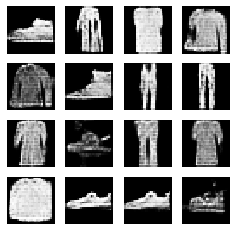

Generator loss     = 0.828841 
Discriminator loss = 1.2980871
epoch :  1  /  100


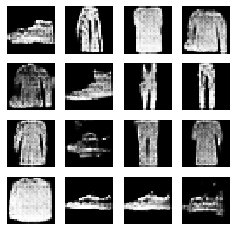

Generator loss     = 0.83176535 
Discriminator loss = 1.289036
epoch :  2  /  100


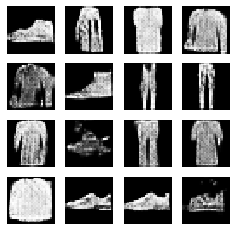

Generator loss     = 0.84081274 
Discriminator loss = 1.2810966
epoch :  3  /  100


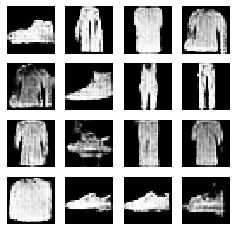

Generator loss     = 0.8476969 
Discriminator loss = 1.2961236
epoch :  4  /  100


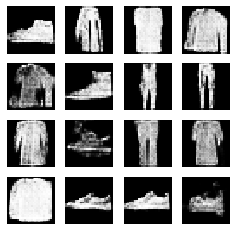

Generator loss     = 0.8775428 
Discriminator loss = 1.2659729
epoch :  5  /  100


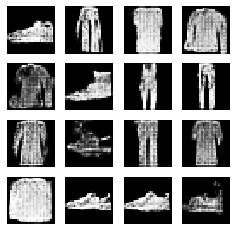

Generator loss     = 0.83695245 
Discriminator loss = 1.2971469
epoch :  6  /  100


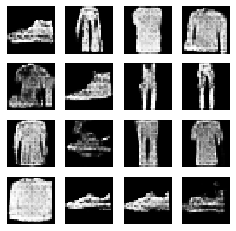

Generator loss     = 0.86711377 
Discriminator loss = 1.2746512
epoch :  7  /  100


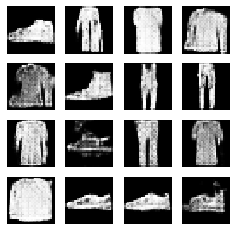

Generator loss     = 0.85827714 
Discriminator loss = 1.2830492
epoch :  8  /  100


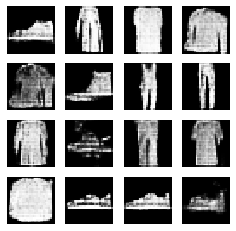

Generator loss     = 0.8615241 
Discriminator loss = 1.2708834
epoch :  9  /  100


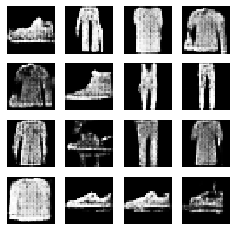

Generator loss     = 0.866314 
Discriminator loss = 1.2741449
epoch :  10  /  100


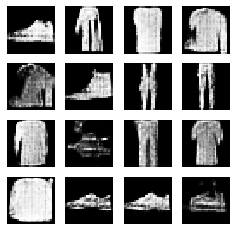

Generator loss     = 0.8710965 
Discriminator loss = 1.2638925
epoch :  11  /  100


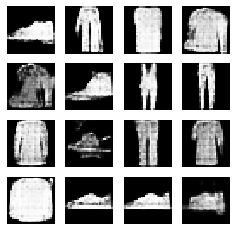

Generator loss     = 0.8851273 
Discriminator loss = 1.2611573
epoch :  12  /  100


KeyboardInterrupt: ignored

In [27]:
import matplotlib.pyplot as plt
import os

discriminator = make_discriminator_model()
discriminator.summary()
discriminator_optimizer = make_discriminator_optimizer()

generator = make_generator_model()
generator.summary()
generator_optimizer =  make_generator_optimizer()

gan_checkpoint_dir = path+'/gan_training_checkpoints'
gan_checkpoint_prefix = os.path.join(gan_checkpoint_dir, "ckpt")
gan_checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#################################################    
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset):
  gan_checkpoint.restore(tf.train.latest_checkpoint(gan_checkpoint_dir))
  for ep in range(epoch):
    print("epoch : ",ep, " / ", epoch)
    gen_losses, disc_losses = [], []
    for it in range(int(dataset.shape[0] / batch_size)):
      image_batch = dataset[np.random.randint(low=0,high=dataset.shape[0],size=batch_size)]
      gen_loss, disc_loss = train_step(image_batch)
      gen_losses.append(gen_loss.numpy())
      disc_losses.append(disc_loss.numpy())

    # Save the model every 15 epochs
    if (ep + 1) % 15 == 0:
      gan_checkpoint.save(file_prefix = gan_checkpoint_prefix)

    generate_and_save_images(generator, ep)

    print("Generator loss     =",mean(gen_losses), "\nDiscriminator loss =",mean(disc_losses))

#################################################    
train(train_images)

## DCAA

#################################################
# DISCRIMINATOR
#################################################
Model: "model_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_200 (LeakyReLU)  (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_201 (LeakyReLU)  (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 3136)              0         
________

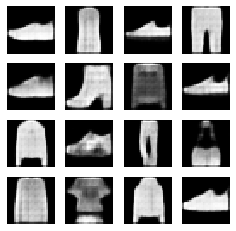

epoch :  0  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2795035696029663
Generator loss = 0.7248483
Discriminator loss = 1.5606691
100 /  234
Autoencoder loss = 0.2800298649072647
Generator loss = 0.7143796
Discriminator loss = 1.5583186
150 /  234
Autoencoder loss = 0.2798339186112086
Generator loss = 0.71015054
Discriminator loss = 1.5453547
200 /  234
Autoencoder loss = 0.2797487555444241
Generator loss = 0.7031768
Discriminator loss = 1.544487


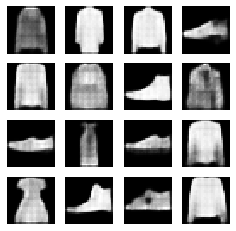

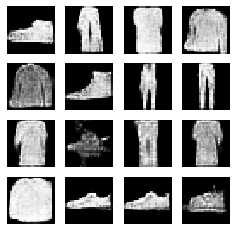

Autoencoder loss = 0.2797120846489556
Generator loss = 0.7008921
Discriminator loss = 1.5408204
epoch :  1  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27919003546237947
Generator loss = 0.6911917
Discriminator loss = 1.4971466
100 /  234
Autoencoder loss = 0.2788484653830528
Generator loss = 0.69319457
Discriminator loss = 1.4978116
150 /  234
Autoencoder loss = 0.278213837146759
Generator loss = 0.6888174
Discriminator loss = 1.4981267
200 /  234
Autoencoder loss = 0.27828621596097947
Generator loss = 0.6908023
Discriminator loss = 1.5025285


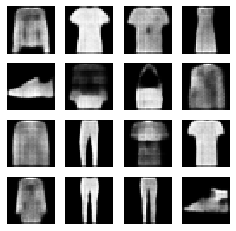

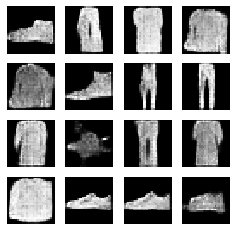

Autoencoder loss = 0.2783855395948785
Generator loss = 0.6898376
Discriminator loss = 1.499947
epoch :  2  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2789819198846817
Generator loss = 0.7016963
Discriminator loss = 1.4765451
100 /  234
Autoencoder loss = 0.2783412745594978
Generator loss = 0.70333266
Discriminator loss = 1.4715233
150 /  234
Autoencoder loss = 0.27786747256914773
Generator loss = 0.7002268
Discriminator loss = 1.4733402
200 /  234
Autoencoder loss = 0.278220679461956
Generator loss = 0.70018965
Discriminator loss = 1.4721414


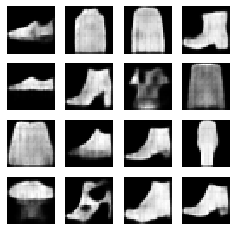

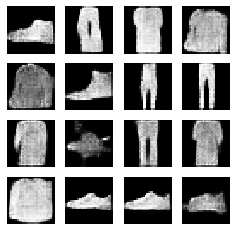

Autoencoder loss = 0.2780508520002039
Generator loss = 0.7002979
Discriminator loss = 1.4675145
epoch :  3  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2788540518283844
Generator loss = 0.7159043
Discriminator loss = 1.444708
100 /  234
Autoencoder loss = 0.27770169973373415
Generator loss = 0.7048782
Discriminator loss = 1.4461468
150 /  234
Autoencoder loss = 0.2773773715893428
Generator loss = 0.71371466
Discriminator loss = 1.4472641
200 /  234
Autoencoder loss = 0.2771993270516396
Generator loss = 0.7115151
Discriminator loss = 1.4434335


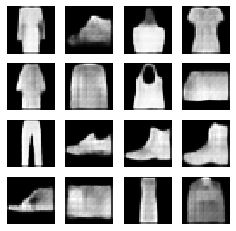

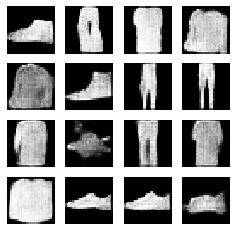

Autoencoder loss = 0.27704965749866944
Generator loss = 0.713509
Discriminator loss = 1.4424467
epoch :  4  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2777460193634033
Generator loss = 0.70673317
Discriminator loss = 1.426005
100 /  234
Autoencoder loss = 0.27850782603025437
Generator loss = 0.70974237
Discriminator loss = 1.4295846
150 /  234
Autoencoder loss = 0.2783880829811096
Generator loss = 0.70861727
Discriminator loss = 1.4281285
200 /  234
Autoencoder loss = 0.27822384536266326
Generator loss = 0.71053076
Discriminator loss = 1.4282672


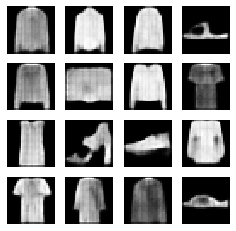

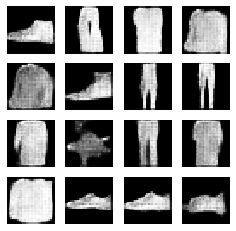

Autoencoder loss = 0.2781854824632661
Generator loss = 0.7114122
Discriminator loss = 1.4296713
epoch :  5  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27701129734516144
Generator loss = 0.71020824
Discriminator loss = 1.4099534
100 /  234
Autoencoder loss = 0.2772076255083084
Generator loss = 0.7219935
Discriminator loss = 1.4247755
150 /  234
Autoencoder loss = 0.2774527090787888
Generator loss = 0.7153888
Discriminator loss = 1.4241086
200 /  234
Autoencoder loss = 0.27744748651981355
Generator loss = 0.72057
Discriminator loss = 1.4274408


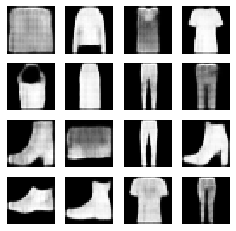

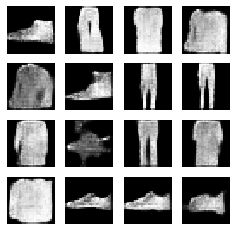

Autoencoder loss = 0.27738206508832103
Generator loss = 0.7197591
Discriminator loss = 1.4243191
epoch :  6  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27842207670211794
Generator loss = 0.7134245
Discriminator loss = 1.4405235
100 /  234
Autoencoder loss = 0.27718785881996155
Generator loss = 0.7099969
Discriminator loss = 1.440157
150 /  234
Autoencoder loss = 0.27707280158996583
Generator loss = 0.7070868
Discriminator loss = 1.4415437
200 /  234
Autoencoder loss = 0.27731774240732193
Generator loss = 0.70635223
Discriminator loss = 1.4453422


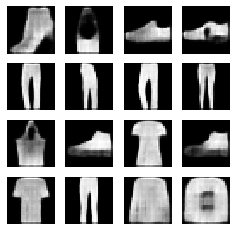

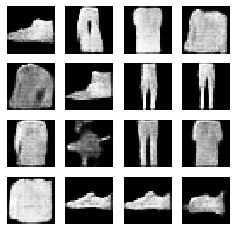

Autoencoder loss = 0.2773812552038421
Generator loss = 0.7090951
Discriminator loss = 1.4352776
epoch :  7  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2761754673719406
Generator loss = 0.69895345
Discriminator loss = 1.4490006
100 /  234
Autoencoder loss = 0.2761637705564499
Generator loss = 0.6958605
Discriminator loss = 1.4546275
150 /  234
Autoencoder loss = 0.27645116527875263
Generator loss = 0.69943964
Discriminator loss = 1.45155
200 /  234
Autoencoder loss = 0.2767163415253162
Generator loss = 0.70180494
Discriminator loss = 1.4436886


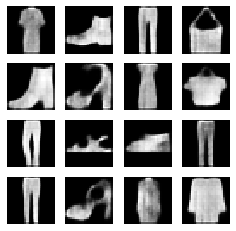

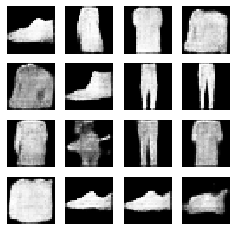

Autoencoder loss = 0.27673690313966864
Generator loss = 0.70933884
Discriminator loss = 1.4399949
epoch :  8  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2760792881250381
Generator loss = 0.70807546
Discriminator loss = 1.4374748
100 /  234
Autoencoder loss = 0.27620008051395417
Generator loss = 0.7177806
Discriminator loss = 1.4368943
150 /  234
Autoencoder loss = 0.27657707353432975
Generator loss = 0.72266275
Discriminator loss = 1.4247061
200 /  234
Autoencoder loss = 0.27688868016004564
Generator loss = 0.7174961
Discriminator loss = 1.4306619


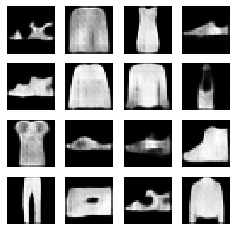

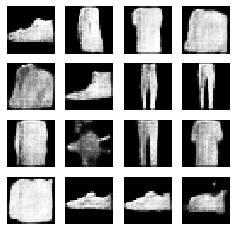

Autoencoder loss = 0.2766309630157601
Generator loss = 0.7164901
Discriminator loss = 1.4363612
epoch :  9  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2763754558563232
Generator loss = 0.71965265
Discriminator loss = 1.3986576
100 /  234
Autoencoder loss = 0.2768762269616127
Generator loss = 0.7211607
Discriminator loss = 1.4166124
150 /  234
Autoencoder loss = 0.27641784290472665
Generator loss = 0.7136567
Discriminator loss = 1.422972
200 /  234
Autoencoder loss = 0.2760647866129875
Generator loss = 0.709383
Discriminator loss = 1.4330968


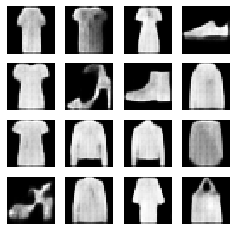

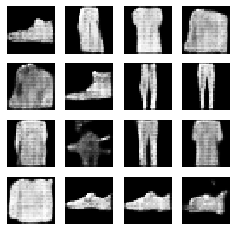

Autoencoder loss = 0.2760747690231372
Generator loss = 0.7070254
Discriminator loss = 1.4348327
epoch :  10  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27738158524036405
Generator loss = 0.70463973
Discriminator loss = 1.4545498
100 /  234
Autoencoder loss = 0.2761552146077156
Generator loss = 0.7058913
Discriminator loss = 1.4371941
150 /  234
Autoencoder loss = 0.2761316619316737
Generator loss = 0.70856667
Discriminator loss = 1.4339963
200 /  234
Autoencoder loss = 0.2759552824497223
Generator loss = 0.7109402
Discriminator loss = 1.4299405


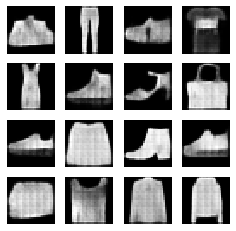

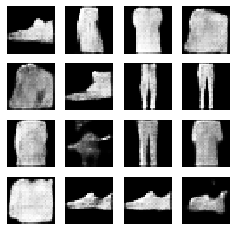

Autoencoder loss = 0.27609035920383584
Generator loss = 0.7103485
Discriminator loss = 1.4316573
epoch :  11  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2748671543598175
Generator loss = 0.72681165
Discriminator loss = 1.3919988
100 /  234
Autoencoder loss = 0.2758598589897156
Generator loss = 0.72254276
Discriminator loss = 1.3999623
150 /  234
Autoencoder loss = 0.2750659078359604
Generator loss = 0.7167634
Discriminator loss = 1.4132096
200 /  234
Autoencoder loss = 0.27531449288129806
Generator loss = 0.71863616
Discriminator loss = 1.4086903


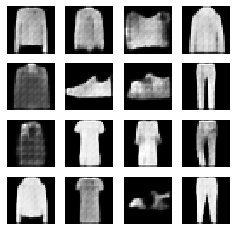

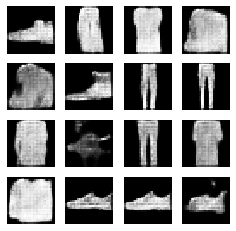

Autoencoder loss = 0.275418599956056
Generator loss = 0.7169122
Discriminator loss = 1.4157765
epoch :  12  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27644258677959443
Generator loss = 0.7374887
Discriminator loss = 1.3848629
100 /  234
Autoencoder loss = 0.27650691956281664
Generator loss = 0.72188747
Discriminator loss = 1.4117781
150 /  234
Autoencoder loss = 0.2761920799811681
Generator loss = 0.7205378
Discriminator loss = 1.4197935
200 /  234
Autoencoder loss = 0.27624370515346525
Generator loss = 0.7237979
Discriminator loss = 1.4127345


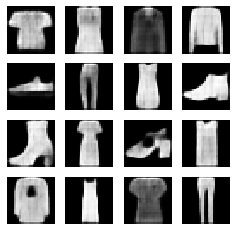

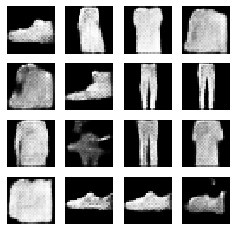

Autoencoder loss = 0.276215342247588
Generator loss = 0.72673327
Discriminator loss = 1.4093692
epoch :  13  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2757343757152557
Generator loss = 0.73995537
Discriminator loss = 1.3919371
100 /  234
Autoencoder loss = 0.27574217051267624
Generator loss = 0.72834307
Discriminator loss = 1.4116652
150 /  234
Autoencoder loss = 0.2758580442269643
Generator loss = 0.73158383
Discriminator loss = 1.4059906
200 /  234
Autoencoder loss = 0.27562311813235285
Generator loss = 0.7258911
Discriminator loss = 1.4100401


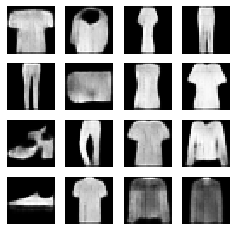

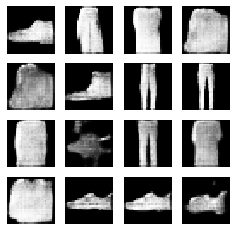

Autoencoder loss = 0.27539316214557386
Generator loss = 0.72895634
Discriminator loss = 1.4070381
epoch :  14  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27575995087623595
Generator loss = 0.7023171
Discriminator loss = 1.4584321
100 /  234
Autoencoder loss = 0.2753922328352928
Generator loss = 0.7192135
Discriminator loss = 1.4244115
150 /  234
Autoencoder loss = 0.27534104307492574
Generator loss = 0.72331345
Discriminator loss = 1.4255062
200 /  234
Autoencoder loss = 0.27534623369574546
Generator loss = 0.7252327
Discriminator loss = 1.4313377


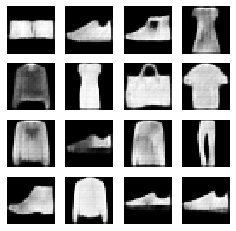

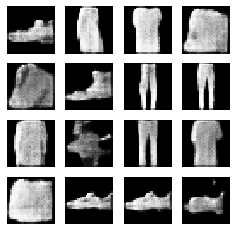

Autoencoder loss = 0.27539091805617016
Generator loss = 0.7284894
Discriminator loss = 1.428045
epoch :  15  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27678481698036195
Generator loss = 0.71855205
Discriminator loss = 1.4680573
100 /  234
Autoencoder loss = 0.27608019977807996
Generator loss = 0.74443996
Discriminator loss = 1.4320503
150 /  234
Autoencoder loss = 0.2756106162071228
Generator loss = 0.7386924
Discriminator loss = 1.4317594
200 /  234
Autoencoder loss = 0.27542322739958763
Generator loss = 0.7408311
Discriminator loss = 1.4158593


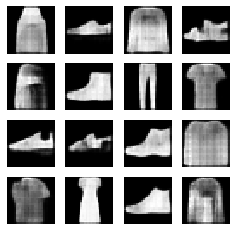

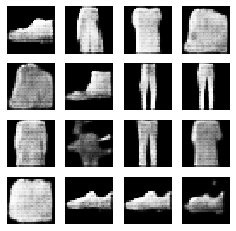

Autoencoder loss = 0.27555299200053907
Generator loss = 0.7306295
Discriminator loss = 1.4328591
epoch :  16  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27505155563354494
Generator loss = 0.758998
Discriminator loss = 1.3480783
100 /  234
Autoencoder loss = 0.2746362429857254
Generator loss = 0.73998153
Discriminator loss = 1.3882447
150 /  234
Autoencoder loss = 0.27469572563966116
Generator loss = 0.73503774
Discriminator loss = 1.3937848
200 /  234
Autoencoder loss = 0.2746621371805668
Generator loss = 0.73156726
Discriminator loss = 1.3948171


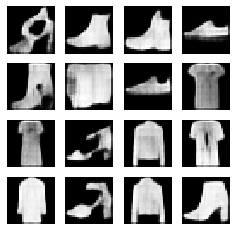

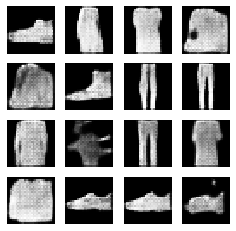

Autoencoder loss = 0.274753163385595
Generator loss = 0.72850007
Discriminator loss = 1.3989716
epoch :  17  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2761976683139801
Generator loss = 0.7402242
Discriminator loss = 1.4031559
100 /  234
Autoencoder loss = 0.2759198293089867
Generator loss = 0.7325823
Discriminator loss = 1.4066684
150 /  234
Autoencoder loss = 0.2760878694057465
Generator loss = 0.7331249
Discriminator loss = 1.3977453
200 /  234
Autoencoder loss = 0.2753161510825157
Generator loss = 0.7222013
Discriminator loss = 1.414637


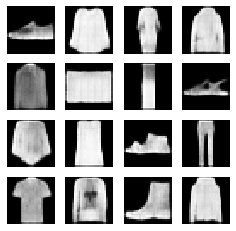

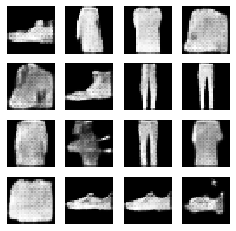

Autoencoder loss = 0.27522531151771545
Generator loss = 0.7259386
Discriminator loss = 1.404923
epoch :  18  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27665603935718536
Generator loss = 0.7095878
Discriminator loss = 1.4314983
100 /  234
Autoencoder loss = 0.27576773256063464
Generator loss = 0.7207275
Discriminator loss = 1.4221164
150 /  234
Autoencoder loss = 0.2749777873357137
Generator loss = 0.72530144
Discriminator loss = 1.4085469
200 /  234
Autoencoder loss = 0.2749883197247982
Generator loss = 0.72202635
Discriminator loss = 1.4128436


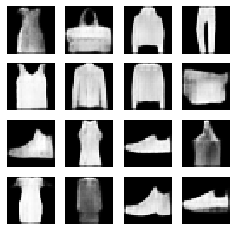

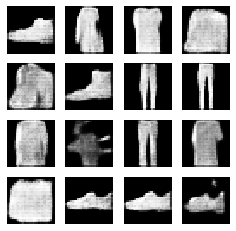

Autoencoder loss = 0.27545636688542163
Generator loss = 0.72890294
Discriminator loss = 1.4005265
epoch :  19  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2742314261198044
Generator loss = 0.7267906
Discriminator loss = 1.4110266
100 /  234
Autoencoder loss = 0.27391151696443555
Generator loss = 0.73240274
Discriminator loss = 1.396489
150 /  234
Autoencoder loss = 0.2740593389670054
Generator loss = 0.7341789
Discriminator loss = 1.3924952
200 /  234
Autoencoder loss = 0.27406837046146393
Generator loss = 0.72848976
Discriminator loss = 1.3981668


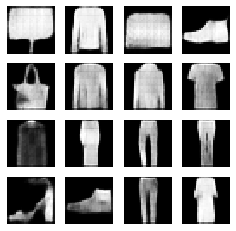

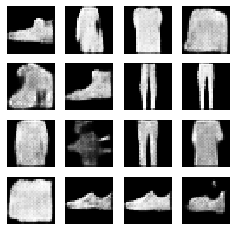

Autoencoder loss = 0.27422132909807384
Generator loss = 0.7352084
Discriminator loss = 1.3881738
epoch :  20  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27509994626045225
Generator loss = 0.7137714
Discriminator loss = 1.428963
100 /  234
Autoencoder loss = 0.27510055869817734
Generator loss = 0.7272671
Discriminator loss = 1.4061135
150 /  234
Autoencoder loss = 0.27437469641367596
Generator loss = 0.7240929
Discriminator loss = 1.4100288
200 /  234
Autoencoder loss = 0.27446812987327573
Generator loss = 0.7191264
Discriminator loss = 1.4183383


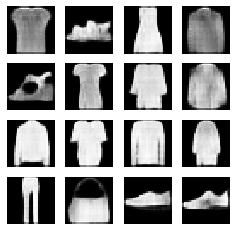

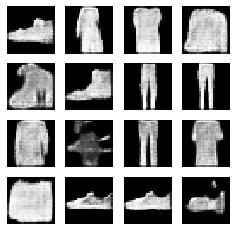

Autoencoder loss = 0.27434279763291025
Generator loss = 0.72847414
Discriminator loss = 1.3992033
epoch :  21  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27517139256000517
Generator loss = 0.68550074
Discriminator loss = 1.4753191
100 /  234
Autoencoder loss = 0.2740267717838287
Generator loss = 0.7136798
Discriminator loss = 1.4179342
150 /  234
Autoencoder loss = 0.2737914049625397
Generator loss = 0.72368085
Discriminator loss = 1.4013209
200 /  234
Autoencoder loss = 0.2737528599798679
Generator loss = 0.72515273
Discriminator loss = 1.398958


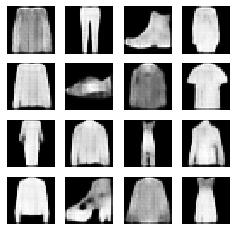

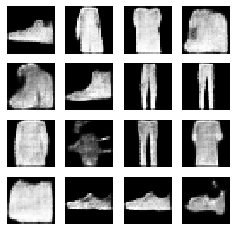

Autoencoder loss = 0.27388854146513164
Generator loss = 0.72942567
Discriminator loss = 1.3903674
epoch :  22  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27292434990406034
Generator loss = 0.71262157
Discriminator loss = 1.4422544
100 /  234
Autoencoder loss = 0.27392051219940183
Generator loss = 0.7350232
Discriminator loss = 1.3875874
150 /  234
Autoencoder loss = 0.27391520698865257
Generator loss = 0.7344739
Discriminator loss = 1.388255
200 /  234
Autoencoder loss = 0.2738274957239628
Generator loss = 0.7273953
Discriminator loss = 1.4000348


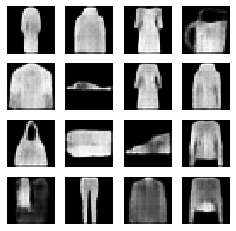

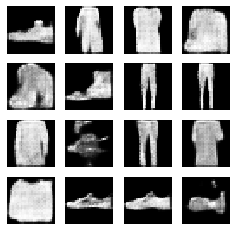

Autoencoder loss = 0.27380305821569556
Generator loss = 0.7319325
Discriminator loss = 1.388911
epoch :  23  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27314643025398255
Generator loss = 0.6933624
Discriminator loss = 1.4671891
100 /  234
Autoencoder loss = 0.27336386680603025
Generator loss = 0.7136969
Discriminator loss = 1.4273821
150 /  234
Autoencoder loss = 0.2738730365037918
Generator loss = 0.72081834
Discriminator loss = 1.4080248
200 /  234
Autoencoder loss = 0.27415273457765577
Generator loss = 0.7199643
Discriminator loss = 1.409053


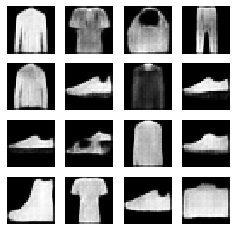

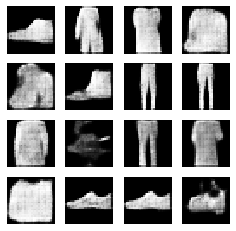

Autoencoder loss = 0.27406466860547024
Generator loss = 0.72409546
Discriminator loss = 1.4008195
epoch :  24  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2735122448205948
Generator loss = 0.7284809
Discriminator loss = 1.3939259
100 /  234
Autoencoder loss = 0.27390393942594526
Generator loss = 0.7307024
Discriminator loss = 1.385511
150 /  234
Autoencoder loss = 0.2734142196178436
Generator loss = 0.7340711
Discriminator loss = 1.3785353
200 /  234
Autoencoder loss = 0.2734035079181194
Generator loss = 0.7340337
Discriminator loss = 1.3813428


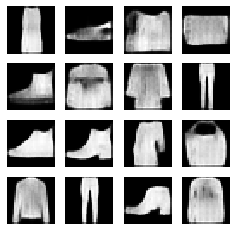

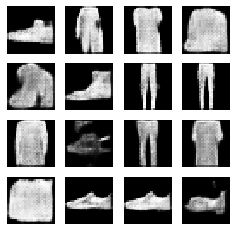

Autoencoder loss = 0.2735941697899093
Generator loss = 0.7348727
Discriminator loss = 1.3825254
epoch :  25  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27388928294181825
Generator loss = 0.7393893
Discriminator loss = 1.3720435
100 /  234
Autoencoder loss = 0.27349712878465654
Generator loss = 0.7387069
Discriminator loss = 1.3799671
150 /  234
Autoencoder loss = 0.27352920174598694
Generator loss = 0.7344592
Discriminator loss = 1.3864511
200 /  234
Autoencoder loss = 0.2736274755001068
Generator loss = 0.7363568
Discriminator loss = 1.3862576


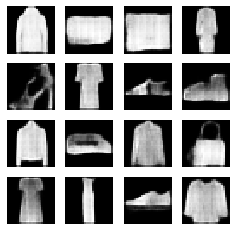

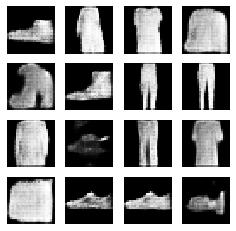

Autoencoder loss = 0.27396114921977377
Generator loss = 0.73231137
Discriminator loss = 1.3930663
epoch :  26  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2732076442241669
Generator loss = 0.7434517
Discriminator loss = 1.4068521
100 /  234
Autoencoder loss = 0.27339854747056963
Generator loss = 0.7301408
Discriminator loss = 1.4123976
150 /  234
Autoencoder loss = 0.273644136985143
Generator loss = 0.7347557
Discriminator loss = 1.4009036
200 /  234
Autoencoder loss = 0.2733584958314896
Generator loss = 0.7345208
Discriminator loss = 1.4022882


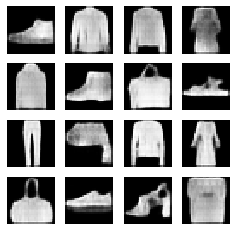

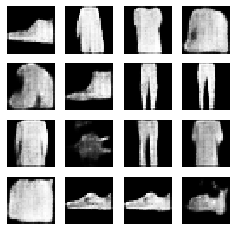

Autoencoder loss = 0.2734003212207403
Generator loss = 0.7356013
Discriminator loss = 1.4056846
epoch :  27  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2737277615070343
Generator loss = 0.72257364
Discriminator loss = 1.456566
100 /  234
Autoencoder loss = 0.27343768179416655
Generator loss = 0.7455153
Discriminator loss = 1.3956983
150 /  234
Autoencoder loss = 0.27356862048308056
Generator loss = 0.7475713
Discriminator loss = 1.3839369
200 /  234
Autoencoder loss = 0.27381584137678144
Generator loss = 0.7462448
Discriminator loss = 1.3835205


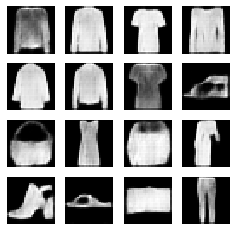

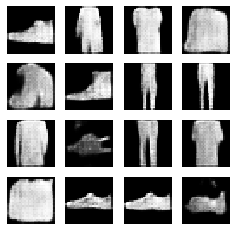

Autoencoder loss = 0.27361407723182285
Generator loss = 0.74631464
Discriminator loss = 1.3823482
epoch :  28  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27342471182346345
Generator loss = 0.7403024
Discriminator loss = 1.3969742
100 /  234
Autoencoder loss = 0.27307375222444535
Generator loss = 0.7456615
Discriminator loss = 1.378655
150 /  234
Autoencoder loss = 0.2730067080259323
Generator loss = 0.73750895
Discriminator loss = 1.3993374
200 /  234
Autoencoder loss = 0.27316783159971236
Generator loss = 0.7334094
Discriminator loss = 1.3980943


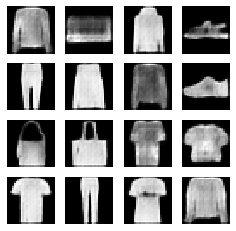

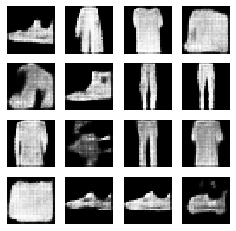

Autoencoder loss = 0.2731293965863366
Generator loss = 0.7369422
Discriminator loss = 1.3908604
epoch :  29  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27405951857566835
Generator loss = 0.697848
Discriminator loss = 1.4659415
100 /  234
Autoencoder loss = 0.27370535254478456
Generator loss = 0.72671646
Discriminator loss = 1.3885307
150 /  234
Autoencoder loss = 0.2737336039543152
Generator loss = 0.72304505
Discriminator loss = 1.3950541
200 /  234
Autoencoder loss = 0.2734480030834675
Generator loss = 0.72405624
Discriminator loss = 1.3945177


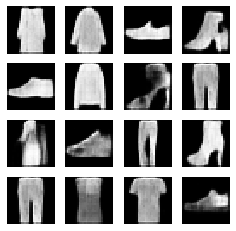

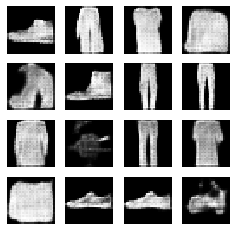

Autoencoder loss = 0.27357475994489133
Generator loss = 0.7278659
Discriminator loss = 1.3837796
epoch :  30  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2748156261444092
Generator loss = 0.7141583
Discriminator loss = 1.4355044
100 /  234
Autoencoder loss = 0.2735963261127472
Generator loss = 0.73672783
Discriminator loss = 1.3803015
150 /  234
Autoencoder loss = 0.27333639562129974
Generator loss = 0.7297918
Discriminator loss = 1.3934021
200 /  234
Autoencoder loss = 0.273092208057642
Generator loss = 0.7320306
Discriminator loss = 1.3853419


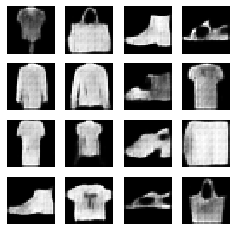

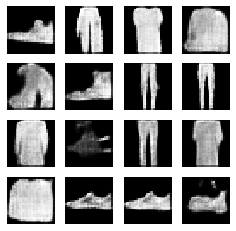

Autoencoder loss = 0.2730781507288289
Generator loss = 0.7320306
Discriminator loss = 1.3853745
epoch :  31  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27258515954017637
Generator loss = 0.7395147
Discriminator loss = 1.3973742
100 /  234
Autoencoder loss = 0.2732225877046585
Generator loss = 0.74174416
Discriminator loss = 1.3762094
150 /  234
Autoencoder loss = 0.27309451580047606
Generator loss = 0.74106354
Discriminator loss = 1.3765488
200 /  234
Autoencoder loss = 0.2733286522328854
Generator loss = 0.7399819
Discriminator loss = 1.3797104


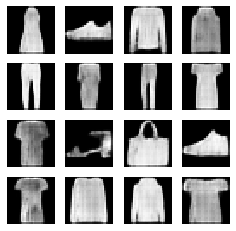

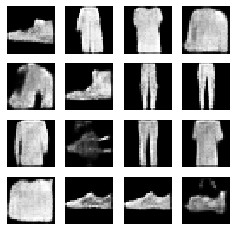

Autoencoder loss = 0.27347401255725795
Generator loss = 0.7425822
Discriminator loss = 1.371003
epoch :  32  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27028295159339905
Generator loss = 0.72148895
Discriminator loss = 1.4146118
100 /  234
Autoencoder loss = 0.271444653570652
Generator loss = 0.73948956
Discriminator loss = 1.3790215
150 /  234
Autoencoder loss = 0.2717760552962621
Generator loss = 0.7325248
Discriminator loss = 1.3843919
200 /  234
Autoencoder loss = 0.27264313384890554
Generator loss = 0.7366343
Discriminator loss = 1.3744619


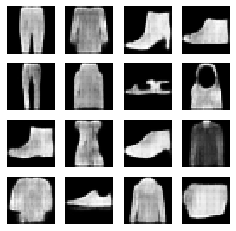

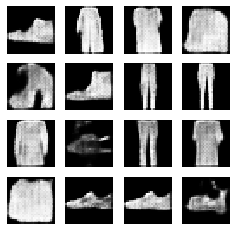

Autoencoder loss = 0.2725667940755176
Generator loss = 0.7341671
Discriminator loss = 1.3791177
epoch :  33  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27233782410621643
Generator loss = 0.72883373
Discriminator loss = 1.3783517
100 /  234
Autoencoder loss = 0.27257812827825545
Generator loss = 0.7335746
Discriminator loss = 1.3654759
150 /  234
Autoencoder loss = 0.2724081981182098
Generator loss = 0.7248045
Discriminator loss = 1.381158
200 /  234
Autoencoder loss = 0.27227419704198835
Generator loss = 0.72804546
Discriminator loss = 1.3753443


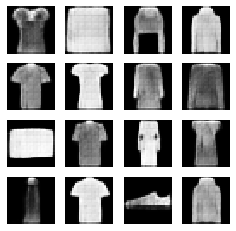

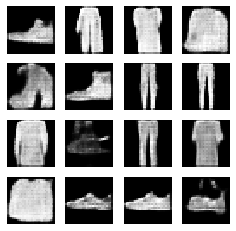

Autoencoder loss = 0.27258175458663547
Generator loss = 0.7292729
Discriminator loss = 1.373936
epoch :  34  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27345929741859437
Generator loss = 0.7321648
Discriminator loss = 1.3869373
100 /  234
Autoencoder loss = 0.2739976304769516
Generator loss = 0.7239996
Discriminator loss = 1.3860991
150 /  234
Autoencoder loss = 0.2738252510627111
Generator loss = 0.72987616
Discriminator loss = 1.3822216
200 /  234
Autoencoder loss = 0.2739334128797054
Generator loss = 0.72358346
Discriminator loss = 1.3917651


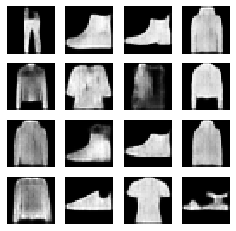

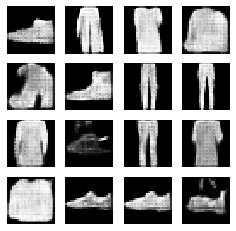

Autoencoder loss = 0.2737062316165011
Generator loss = 0.7290749
Discriminator loss = 1.3816946
epoch :  35  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2726541769504547
Generator loss = 0.7210258
Discriminator loss = 1.3966843
100 /  234
Autoencoder loss = 0.27263203978538514
Generator loss = 0.7115217
Discriminator loss = 1.4197626
150 /  234
Autoencoder loss = 0.27283852616945903
Generator loss = 0.7202403
Discriminator loss = 1.4088051
200 /  234
Autoencoder loss = 0.2726715913414955
Generator loss = 0.72273254
Discriminator loss = 1.4018048


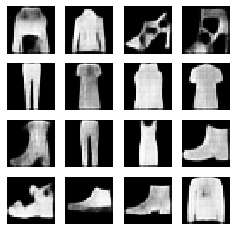

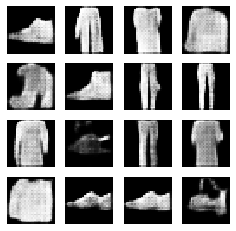

Autoencoder loss = 0.272778518179543
Generator loss = 0.7215929
Discriminator loss = 1.4079697
epoch :  36  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2731081122159958
Generator loss = 0.76271397
Discriminator loss = 1.3379085
100 /  234
Autoencoder loss = 0.27222901791334153
Generator loss = 0.74573493
Discriminator loss = 1.3609614
150 /  234
Autoencoder loss = 0.2720205835501353
Generator loss = 0.7479056
Discriminator loss = 1.3602678
200 /  234
Autoencoder loss = 0.27187971010804174
Generator loss = 0.7466989
Discriminator loss = 1.3599143


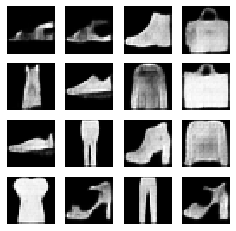

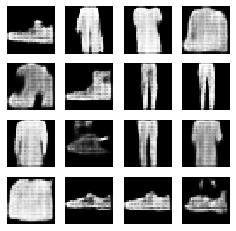

Autoencoder loss = 0.2720870244452077
Generator loss = 0.7386124
Discriminator loss = 1.3794639
epoch :  37  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27242147564888003
Generator loss = 0.76814127
Discriminator loss = 1.3067812
100 /  234
Autoencoder loss = 0.27263030111789704
Generator loss = 0.7413556
Discriminator loss = 1.3815459
150 /  234
Autoencoder loss = 0.2728774505853653
Generator loss = 0.7452641
Discriminator loss = 1.362629
200 /  234
Autoencoder loss = 0.27331538379192355
Generator loss = 0.7440518
Discriminator loss = 1.3745857


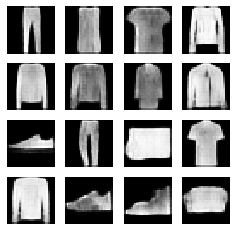

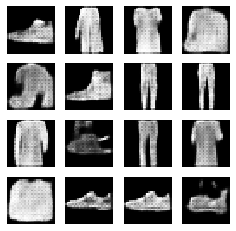

Autoencoder loss = 0.2729789046650259
Generator loss = 0.7468304
Discriminator loss = 1.3704029
epoch :  38  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27167543411254885
Generator loss = 0.740155
Discriminator loss = 1.3553133
100 /  234
Autoencoder loss = 0.2714888739585877
Generator loss = 0.7303497
Discriminator loss = 1.3821393
150 /  234
Autoencoder loss = 0.27169777611891427
Generator loss = 0.741276
Discriminator loss = 1.3610448
200 /  234
Autoencoder loss = 0.2717872828245163
Generator loss = 0.73728114
Discriminator loss = 1.3777479


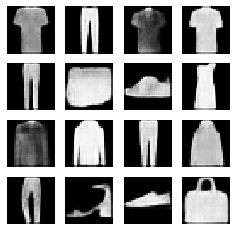

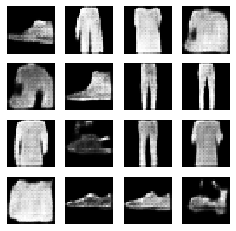

Autoencoder loss = 0.27191510096064997
Generator loss = 0.74079615
Discriminator loss = 1.3686829
epoch :  39  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2740390318632126
Generator loss = 0.7455591
Discriminator loss = 1.3640099
100 /  234
Autoencoder loss = 0.27264670431613924
Generator loss = 0.7342699
Discriminator loss = 1.3713139
150 /  234
Autoencoder loss = 0.2723745975891749
Generator loss = 0.7439646
Discriminator loss = 1.3550645
200 /  234
Autoencoder loss = 0.27237753495573996
Generator loss = 0.7407638
Discriminator loss = 1.3641607


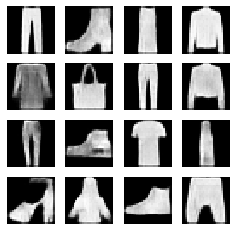

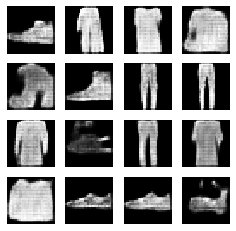

Autoencoder loss = 0.27230184595299584
Generator loss = 0.7412914
Discriminator loss = 1.3589985
epoch :  40  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2717248260974884
Generator loss = 0.7202853
Discriminator loss = 1.4090784
100 /  234
Autoencoder loss = 0.27172886043787003
Generator loss = 0.73142314
Discriminator loss = 1.3805207
150 /  234
Autoencoder loss = 0.27202330986658735
Generator loss = 0.72684765
Discriminator loss = 1.3863277
200 /  234
Autoencoder loss = 0.27229981392621994
Generator loss = 0.7298328
Discriminator loss = 1.3834652


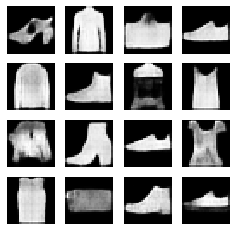

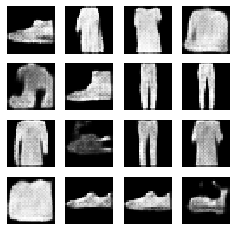

Autoencoder loss = 0.27238419308112216
Generator loss = 0.7309166
Discriminator loss = 1.3780059
epoch :  41  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27249231457710266
Generator loss = 0.7278861
Discriminator loss = 1.3721601
100 /  234
Autoencoder loss = 0.27176101624965665
Generator loss = 0.736286
Discriminator loss = 1.3608316
150 /  234
Autoencoder loss = 0.27172211567560833
Generator loss = 0.73589045
Discriminator loss = 1.3646396
200 /  234
Autoencoder loss = 0.2727234850823879
Generator loss = 0.73343784
Discriminator loss = 1.379303


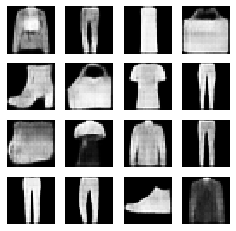

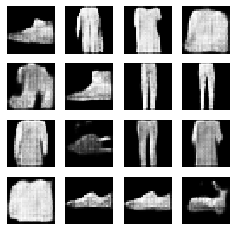

Autoencoder loss = 0.2726125462442382
Generator loss = 0.73606163
Discriminator loss = 1.3704102
epoch :  42  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27238466441631315
Generator loss = 0.7031943
Discriminator loss = 1.4619473
100 /  234
Autoencoder loss = 0.27246042728424075
Generator loss = 0.7233596
Discriminator loss = 1.4057472
150 /  234
Autoencoder loss = 0.27226322929064434
Generator loss = 0.7315219
Discriminator loss = 1.399562
200 /  234
Autoencoder loss = 0.27203031197190286
Generator loss = 0.73531216
Discriminator loss = 1.3966894


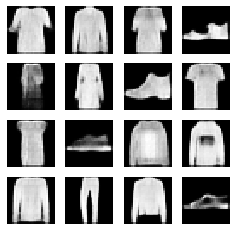

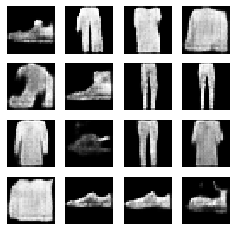

Autoencoder loss = 0.27199973471653766
Generator loss = 0.7385083
Discriminator loss = 1.3880738
epoch :  43  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2712718611955643
Generator loss = 0.7411624
Discriminator loss = 1.4008377
100 /  234
Autoencoder loss = 0.2710492578148842
Generator loss = 0.7439037
Discriminator loss = 1.3762361
150 /  234
Autoencoder loss = 0.27163282851378123
Generator loss = 0.7427526
Discriminator loss = 1.3820214
200 /  234
Autoencoder loss = 0.27171858578920366
Generator loss = 0.739697
Discriminator loss = 1.3831481


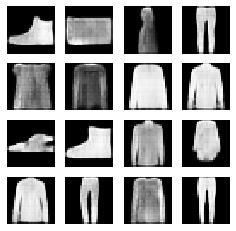

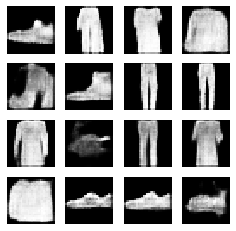

Autoencoder loss = 0.2716974084958052
Generator loss = 0.74452156
Discriminator loss = 1.3744835
epoch :  44  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27220805823802946
Generator loss = 0.72754127
Discriminator loss = 1.3823869
100 /  234
Autoencoder loss = 0.2722427251935005
Generator loss = 0.7331145
Discriminator loss = 1.3724443
150 /  234
Autoencoder loss = 0.27155288338661193
Generator loss = 0.7410002
Discriminator loss = 1.3580704
200 /  234
Autoencoder loss = 0.27175477996468544
Generator loss = 0.7361132
Discriminator loss = 1.3655056


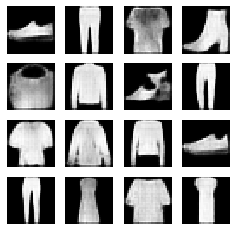

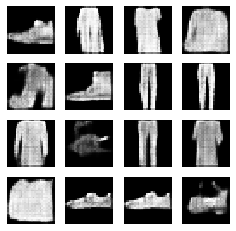

Autoencoder loss = 0.27213131375292426
Generator loss = 0.7352841
Discriminator loss = 1.3660507
epoch :  45  /  100
0 /  234
50 /  234
Autoencoder loss = 0.2735612618923187
Generator loss = 0.7258844
Discriminator loss = 1.3902377
100 /  234
Autoencoder loss = 0.27222630351781846
Generator loss = 0.73643875
Discriminator loss = 1.3785076
150 /  234
Autoencoder loss = 0.27174168288707734
Generator loss = 0.7292157
Discriminator loss = 1.386626
200 /  234
Autoencoder loss = 0.27195953994989397
Generator loss = 0.74005723
Discriminator loss = 1.3742409


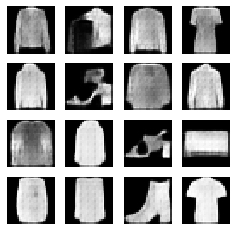

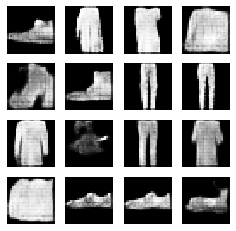

Autoencoder loss = 0.2718213433638597
Generator loss = 0.73534364
Discriminator loss = 1.3792449
epoch :  46  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27167064845561983
Generator loss = 0.73294723
Discriminator loss = 1.3568851
100 /  234
Autoencoder loss = 0.27187073349952695
Generator loss = 0.7414084
Discriminator loss = 1.3588284
150 /  234
Autoencoder loss = 0.2717998611927033
Generator loss = 0.7336507
Discriminator loss = 1.3708419
200 /  234
Autoencoder loss = 0.2718725401163101
Generator loss = 0.7355614
Discriminator loss = 1.3646318


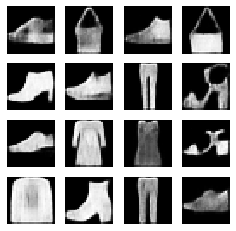

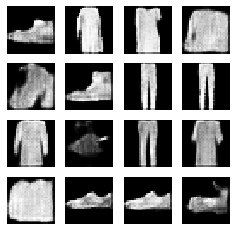

Autoencoder loss = 0.2719123432269463
Generator loss = 0.7334418
Discriminator loss = 1.3664268
epoch :  47  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27026238679885867
Generator loss = 0.7264315
Discriminator loss = 1.3791883
100 /  234
Autoencoder loss = 0.27006250381469726
Generator loss = 0.73381186
Discriminator loss = 1.3675026
150 /  234
Autoencoder loss = 0.2706687937180201
Generator loss = 0.7352684
Discriminator loss = 1.364435
200 /  234
Autoencoder loss = 0.2708191713690758
Generator loss = 0.73458135
Discriminator loss = 1.3633066


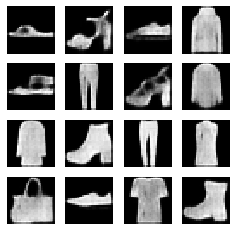

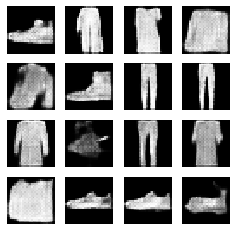

Autoencoder loss = 0.271024562482141
Generator loss = 0.73308265
Discriminator loss = 1.3650471
epoch :  48  /  100
0 /  234
50 /  234
Autoencoder loss = 0.27144706130027774
Generator loss = 0.7454295
Discriminator loss = 1.3662665
100 /  234
Autoencoder loss = 0.27182746201753616
Generator loss = 0.7369613
Discriminator loss = 1.3637048


In [0]:
import matplotlib.pyplot as plt

print("#################################################\n# DISCRIMINATOR\n#################################################")
discriminator = make_discriminator_model()
#discriminator.compile(optimizer=make_discriminator_optimizer(), loss='binary_crossentropy')
discriminator.summary()
discriminator_optimizer = make_discriminator_optimizer()

print("#################################################\n#GENERATOR\n#################################################")
generator = make_generator_model()
generator.summary()
generator_optimizer =  make_generator_optimizer()

print("#################################################\n# AUTOENCODER\n#################################################")
autoencoder, _, _ = make_conv_autoencoder_model()
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')
autoencoder.summary()
autoencoder_optimizer = make_optimizer()

"""print("#################################################\n# AAE\n#################################################")
aae = make_aae(autoencoder, discriminator)
aae.summary()"""

"""print("#################################################\n# GAN\n#################################################")
gan = make_gan(generator, discriminator)
gan.summary()"""


gan_checkpoint_dir = path+'/gan_training_checkpoints'
gan_checkpoint_prefix = os.path.join(gan_checkpoint_dir, "ckpt")
gan_checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


#################################################    
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as ae_tape:
      images = autoencoder(images, training=True)

      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      ae_loss = autoencoder_loss(real_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gradients_of_autoencoder = ae_tape.gradient(ae_loss, autoencoder.trainable_variables)    

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    autoencoder_optimizer.apply_gradients(zip(gradients_of_autoencoder, autoencoder.trainable_variables))

    return gen_loss, disc_loss, ae_loss



def train(dataset):
  gan_checkpoint.restore(tf.train.latest_checkpoint(gan_checkpoint_dir))

  # Autoencoder pre-training
  autoencoder.fit(dataset, dataset,
                epochs=10,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(test_images, test_images))
  
  generate_and_save_images(autoencoder, -1, norm=1,
                           test_input=dataset[np.random.randint(low=0,high=dataset.shape[0],size=num_examples_to_generate)])

  # Training pipeline
  for ep in range(epoch):
    print("epoch : ",ep, " / ", epoch)
    losses = {"Autoencoder":[],"GAN":[],"AAE":[],"Generator":[],"Discriminator":[]}
    #gen_losses, disc_losses, ae_losses, aae_losses, gan_losses = [], [], [], [], []
    for it in range(int(dataset.shape[0] / batch_size)):
      image_batch = dataset[np.random.randint(low=0,high=dataset.shape[0],size=batch_size)]

      # Print current losses
      if it % 50 == 0:
        print(it,"/ ",int(dataset.shape[0] / batch_size))
        for name in losses:
          if losses[name] != []:
            print(name, "loss =", mean(losses[name]))

      # Autoencoder training
      history = autoencoder.fit(image_batch, image_batch,
                epochs=1, verbose=0,
                batch_size=batch_size,
                shuffle=True)#,
                #validation_data=(test_images, test_images))
      losses["Autoencoder"].append(history.history['loss'][0])

      # Adversarial Autoencoder training
      """if ep > gan_pre_training_step:
        history = aae.fit(image_batch, np.ones(batch_size),
                  epochs=1, verbose=0,
                  batch_size=batch_size,
                  shuffle=True)
        losses["AAE"].append(history.history['loss'][0])
        # Prepare encoded images for GAN
        image_batch = autoencoder(image_batch, training=True)"""

      # GAN training
      gen_loss, disc_loss, aae_loss = train_step(image_batch)
      losses["Generator"].append(gen_loss.numpy())
      losses["Discriminator"].append(disc_loss.numpy())
      #losses["AAE"].append(aae_loss.numpy())

      """# GAN training      
      history = gan.fit(tf.random.normal([batch_size, noise_dim]), np.ones(batch_size),
                epochs=1, verbose=0,
                batch_size=batch_size,
                shuffle=True)
      losses["GAN"].append(history.history['loss'][0])

      generated_images = generate_images(batch_size, noise_dim, generator)
      history = discriminator.fit(generated_images, np.zeros(batch_size),
                epochs=1, verbose=0,
                batch_size=batch_size,
                shuffle=True)
      losses["Discriminator"].append(history.history['loss'][0])"""

    # Plot images
    generate_and_save_images(autoencoder, -1*epoch, norm=1,
                            test_input=dataset[np.random.randint(low=0,high=dataset.shape[0],size=num_examples_to_generate)])
    generate_and_save_images(generator, ep)

    # Print results
    for name in losses:
        if losses[name] != []:
          print(name, "loss =", mean(losses[name]))

#################################################    
train(train_images)